In [1]:
%matplotlib inline



# Incremental PCA


Incremental principal component analysis (IPCA) is typically used as a
replacement for principal component analysis (PCA) when the dataset to be
decomposed is too large to fit in memory. IPCA builds a low-rank approximation
for the input data using an amount of memory which is independent of the
number of input data samples. It is still dependent on the input data features,
but changing the batch size allows for control of memory usage.

Here the proyection of days using the R vector (i.e. the correlation vector) such that, we can see how the trainned Hidden Markov Model HMM is able to separate the different samples. Observe that is not easy a separation between clusters: {Weekend , Working days}. From the HMM analysis, we know that the holidays cannot be cluster in only one group because holidays are dispersed over all the components.

In [2]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from sklearn.decomposition import PCA, IncrementalPCA
from pymongo import MongoClient
from sklearn.externals import joblib

import plotly.offline as py
import plotly.graph_objs as go  #important library for the plotly
#import cufflinks as cf
import pylab as pl
from IPython.display import display

py.init_notebook_mode(connected=False) # run at the start of every ipython notebook to use plotly.offline
from plotly import tools #to do subplots

import sys
sys.path.append('../../../lib')
import rs_common_framework_v4 as rs
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

Automatically created module for IPython interactive environment


In [3]:
print("\t Connected to Mongo DB")
daily_vector = 'vector_daily'
#daily_vector = 'C_1-C_2-C_4'
daily_vector = 'C_1-C_4'
day_type = ['working_day', 'weekend', 'holiday']
connection = MongoClient('localhost') #"192.168.6.132"
collection_metadata = connection["project_db"]["metadata"] 
collection_series = connection["project_db"]["filtered_time_series"]
collection_daily_vector = connection["project_db"][daily_vector]
collection_statistics = connection["project_db"]["statistics_daily"]

	 Connected to Mongo DB


In [4]:
#path_model = '../../../HMM_models/Draft_models/hmm_S_vector_A.pkl'
file_name = 'hmm_S_vector_C_' + daily_vector + '_15.pkl'
#file_name = 'named_hmm_S_vector_C_' + daily_vector + '_20.pkl'

path_model = '../../../HMM_models/Draft_models/' + file_name
#path_model = '../../../HMM_models/Final_models/' + file_name
print("\tReading the HMM model: {0}".format(path_model))
#named_model = joblib.load(path_model)
#model = named_model['model']
#label_model = named_model['hidden_state_name']
model = joblib.load(path_model)
n_comp = model.n_components

print("\t-- The trained model has {0} hidden states".format(n_comp))

	Reading the HMM model: ../../../HMM_models/Draft_models/hmm_S_vector_C_C_1-C_4_15.pkl
	-- The trained model has 4 hidden states


In [5]:
selected_category = 'C'
vector_name = 'S_vector'
filter_query = {"breakout_group": selected_category,
                'day_type': {'$in': day_type}}


timeline = rs.get_timeline(collection_daily_vector, filter_query, freq=None)

# This obtain a normalized vector based on the general mean and general std. (Z-score normalization)
# the general mean and std does not apply the filter_query

#df_norm = rs.get_samples_norm_vector(collection_daily_vector, timeline, filter_query, vector_name)
df_norm = rs.get_vector(collection_daily_vector, timeline, filter_query, vector_name)

n = len(df_norm.index)
X = np.array(df_norm)

start_time = timeline[0]
end_time = timeline[-1]

day_type_list = list()
weekday_name = list()

fr = list()
vector_name = 'S_vector'
for timestamp in timeline:

    day_type = ['weekend', 'working_day', 'holiday']
    
    projection = {vector_name: True, 'day_type': True, 'weekday_name': True}
    filter_query = {"breakout_group" : selected_category, 
                    'timestamp': timestamp,
                    'day_type': { '$in': day_type } }
    dictionaries = collection_daily_vector.find_one(filter_query, projection)
    if not dictionaries is None:
        day_type_list.append(dictionaries['day_type'])
        weekday_name.append(dictionaries['weekday_name'])
        if np.isnan(sum(dictionaries[vector_name])):
            print(timestamp)
        
#df_x.reset_index(inplace=True)
print("\tAnalysis from {0} to {1}, {2} samples, shape of the samples.".format(start_time, end_time, n))
print("\tThe X vector has the shape: {0}. This vector is based on {1}".format(X.shape, vector_name))


	Analysis from 2012-06-23 to 2015-06-08, 1081 samples, shape of the samples.
	The X vector has the shape: (1081, 12). This vector is based on S_vector


In [6]:
y = model.predict(X)  # based on R vector 
print('\t Infering the hidden states from {0} samples: \n\t {1}'.format(len(X),y))

	 Infering the hidden states from 1081 samples: 
	 [0 2 0 ..., 0 0 0]


In [7]:
n_components = 3 #to visualize in a 3D space (x,y,z)

#label_states = ['S'+ str(i+1) for i in range(n_comp)] #for hidden states
label_name = ['S'+ str(i+1) for i in range(n_comp)] 

#label_name = label_model
#ipca = IncrementalPCA(n_components=n_components, batch_size=500)
#X_ipca = ipca.fit_transform(X)

df_t = rs.get_vector(collection_daily_vector, timeline, filter_query, vector_name)
Xp = np.array(df_t)

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(Xp)

df = pd.DataFrame(X_pca, columns = ['x_cord','y_cord','z_cord'])
df['hidden_state'] = y
#df['day_type'] = day_type_list
#df['weekday_name'] = weekday_name
#df['y_pca'] = 3 #by default means outlier_days

print(df.head(5))
print(len(df.index))

      x_cord    y_cord    z_cord  hidden_state
0  27.862788  3.860525 -0.130931             0
1  26.959489  4.470085  0.210102             2
2  24.476324 -1.021762  1.563405             0
3  25.909270  2.624018  1.145144             0
4  32.746124  7.496702 -3.143252             0
1081


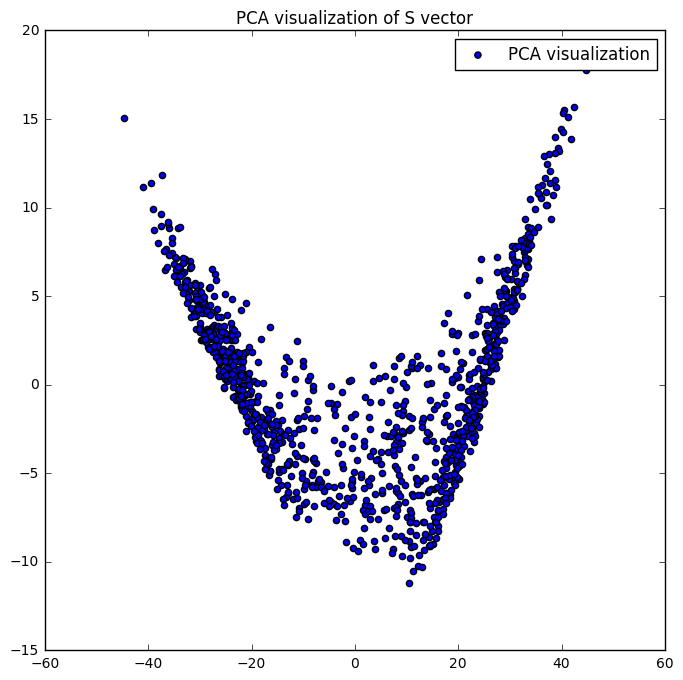

In [8]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(df['x_cord'], df['y_cord'], label='PCA visualization')
title ="PCA visualization of S vector"
plt.title(title)

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.show()

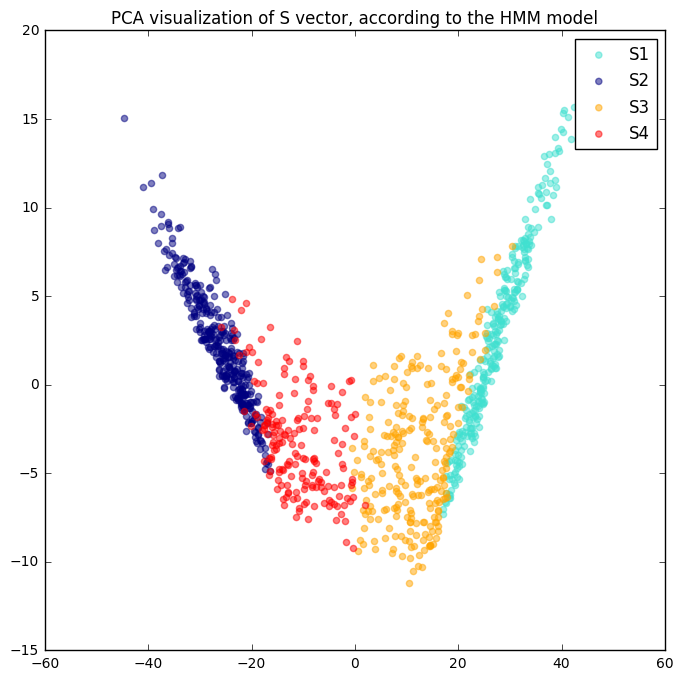

In [9]:
#label_name = ['S1', 'S2', 'S3', 'S4']

colors = ['turquoise', 'navy' , 'orange', 'red']

fig = plt.figure(figsize=(8, 8))
#ax = fig.add_subplot(111, projection='3d')

for color, i, target_name in zip(colors, range(n_comp), label_name):
    mask = (df['hidden_state'] == i)
    # print(df[mask])
    plt.scatter(df.loc[mask,'x_cord'], df.loc[mask,'y_cord'],
                color=color, lw=1, label=target_name, alpha=0.5)
    
    #plt.scatter(X_transformed[y == i, 0], X_transformed[y == i, 1],
    #            color=color, lw=1, label=target_name)

plt.title(title +", according to the HMM model")

plt.legend(loc="best", shadow=False, scatterpoints=1)
#plt.axis([-1.5, 4, -1.5, 1.5])


plt.show()

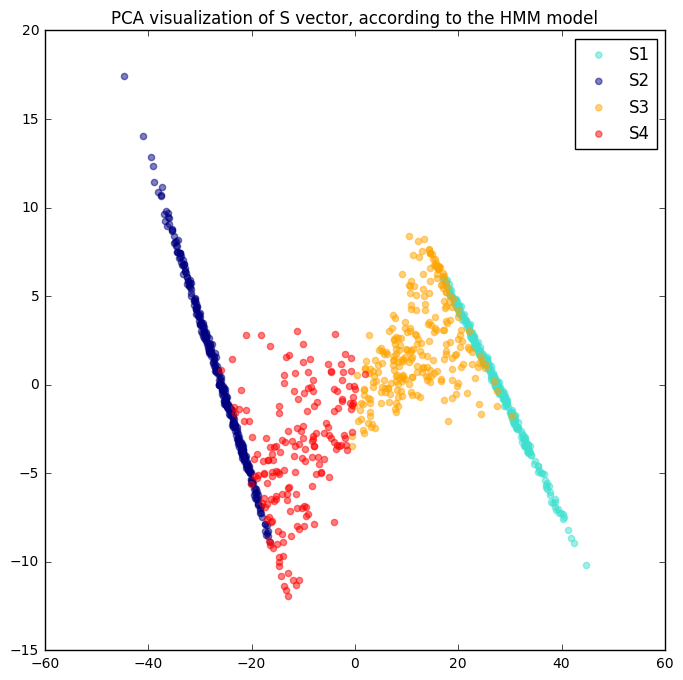

In [10]:
#label_name = ['S1', 'S2', 'S3', 'S4']

fig = plt.figure(figsize=(8, 8))
#ax = fig.add_subplot(111, projection='3d')

for color, i, target_name in zip(colors, [0, 1, 2, 3], label_name):
    mask = (df['hidden_state'] == i)
    plt.scatter(df.loc[mask,'x_cord'], df.loc[mask,'z_cord'],
                color=color, lw=1, label=target_name, alpha=0.5)
    
    #plt.scatter(X_transformed[y == i, 0], X_transformed[y == i, 1],
    #            color=color, lw=1, label=target_name)

plt.title(title + ", according to the HMM model")

plt.legend(loc="best", shadow=False, scatterpoints=1)
#plt.axis([-1.5, 4, -1.5, 1.5])


plt.show()

In [11]:

data = list()
for color, i, target_name in zip(colors, range(n_comp), label_name):
    mask = (df['hidden_state'] == i)
    
    trace = go.Scatter3d(
        x= df.loc[mask,'x_cord'],
        y= df.loc[mask,'y_cord'],
        z= df.loc[mask,'z_cord'],
        name=target_name,
        mode='markers',
        marker=dict(
            size=2,
            opacity=1,
            color=color
        )
    )
    
    data.append(trace)
    
fig = go.Figure(data=data)
py.iplot(fig)

(291, 12)


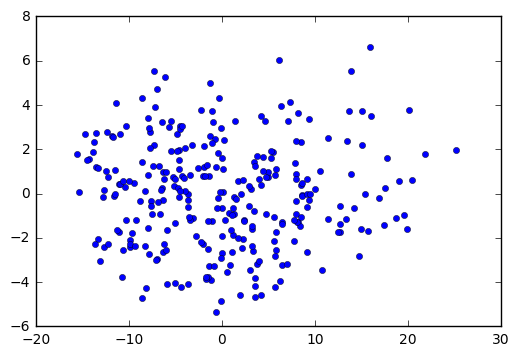

(348, 12)


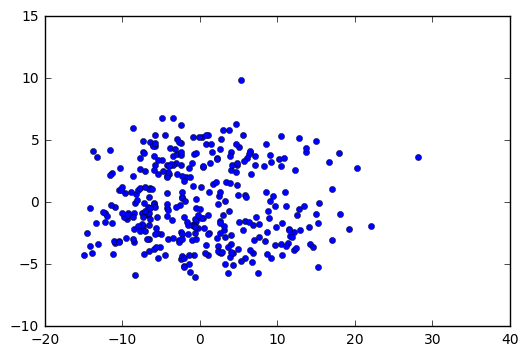

(262, 12)


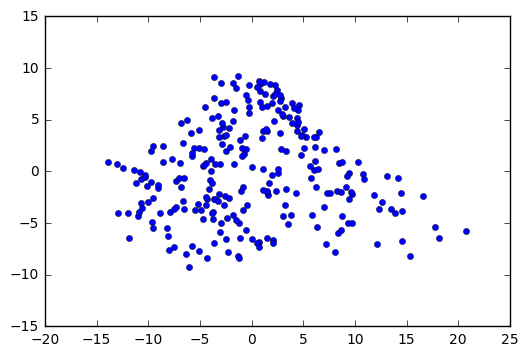

(180, 12)


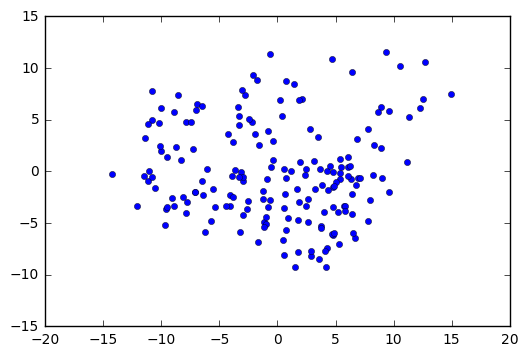

In [12]:
n_components = 3 #to visualize in a 3D space (x,y,z)
df.index = timeline
for idx, idy in zip(range(n_comp),label_name): #this according to the HMM model 
    mask = (df['hidden_state'] == idx) 
    X = np.array(df_t.loc[mask])
    print(X.shape)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    df_sub = pd.DataFrame(X_pca, columns = ['x_cord','y_cord','z_cord'])
    plt.scatter(df_sub['x_cord'], df_sub['y_cord'], lw=0.3)
    plt.show()

In [13]:
data_t = dict()
for t in timeline:
    data_t[t] = df['hidden_state'].loc[t]
json = {'Data': data_t}
print(json)

{'Data': {'2015-04-04': 1, '2013-09-12': 2, '2014-03-06': 3, '2012-12-04': 1, '2014-05-29': 2, '2013-07-14': 0, '2012-08-30': 0, '2015-05-28': 2, '2013-12-16': 1, '2015-03-30': 3, '2012-06-27': 0, '2012-12-08': 1, '2012-12-30': 1, '2014-07-11': 0, '2014-08-23': 2, '2015-01-24': 1, '2015-05-20': 3, '2015-03-07': 1, '2014-10-03': 2, '2013-04-14': 2, '2015-05-15': 3, '2012-09-27': 2, '2014-01-06': 1, '2014-10-12': 2, '2014-03-15': 3, '2013-09-30': 2, '2015-05-08': 2, '2012-06-24': 2, '2014-10-15': 2, '2015-05-19': 2, '2012-10-29': 1, '2013-04-17': 2, '2014-04-02': 2, '2014-03-05': 1, '2014-08-19': 0, '2015-01-28': 1, '2014-12-18': 3, '2015-02-28': 1, '2012-08-25': 0, '2013-05-07': 0, '2015-02-17': 1, '2013-01-01': 1, '2012-09-24': 0, '2013-04-29': 2, '2013-08-24': 0, '2014-06-20': 0, '2015-02-18': 1, '2014-12-20': 1, '2013-09-28': 0, '2015-05-14': 0, '2015-03-05': 1, '2013-12-05': 1, '2014-10-07': 2, '2013-04-30': 2, '2013-11-05': 3, '2013-05-13': 2, '2014-08-31': 0, '2013-10-17': 2, '201

# 